In [1]:
%matplotlib inline

# DeepFake1 (cntk)

![deepfake](../Images/faceswap.jpg)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
import pylab
import PIL  
from PIL import Image
import os
import pickle
import codecs
import glob
import math
import cv2
import cntk as C
from cntk.ops import *
from cntk.layers import *
from cntk.initializer import *
from cntk.logging import *
from cntk.train import *
from cntk.learners import *
from cntk.losses import *
from cntk.metrics import *
from cntk.device import *
import random

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
def umeyama(src, dst, estimate_scale):
    """估計N維相似性轉換參數(可處理有無縮放之狀況) 
    ----------
    src : (M, N) array
        來源點座標
    dst : (M, N) array
        參考點座標
    estimate_scale : bool
        是否估計縮放因子
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    
    參考文獻
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # 計算src 以及 dst的均值
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    #將 src 與 dst 減去均值
    src_demean = src - src_mean
    dst_demean = dst  - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [4]:
#圖片轉向量
def img2array(img: Image):
    arr = np.array(img).astype(np.float32)
    arr=arr.transpose(2, 0, 1) #轉成CHW
    arr=np.ascontiguousarray(arr)
    return arr[::-1] #顏色排序為BGR

#向量轉圖片
def array2img(arr: np.ndarray):
    arr =arr[::-1]#轉成RGB
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img

#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-8,8))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(cv2image,gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    cv2.LUT(cv2image.astype(np.uint8), table)
    return cv2image

#模糊
def adjust_blur(cv2image):
    cv2image=cv2.blur(cv2image, (5, 5))
    return cv2image

def get_motion_blur_kernel(sz=7):
    rot_angle = np.random.uniform(-180, 180)
    kernel = np.zeros((sz, sz))
    kernel[int((sz - 1) // 2), :] = np.ones(sz)
    kernel = ndimage.interpolation.rotate(kernel, rot_angle, reshape=False)
    kernel = np.clip(kernel, 0, 1)
    normalize_factor = 1 / np.sum(kernel)
    kernel = kernel * normalize_factor
    return kernel

#動態模糊
def motion_blur(image, sz=7):
    blur_sz = np.random.choice([5, 7, 9, 11])
    kernel_motion_blur = get_motion_blur_kernel(blur_sz)
    image = cv2.filter2D(image, -1, kernel_motion_blur).astype(np.float64)
    return image

# 把現有的圖片隨機擾亂
coverage = 110
rotation_range =10
zoom_range = 0.05
shift_range =0.05
random_flip = 0.4

#對圖片進行平移(微量)、縮放(微量)、旋轉(微量)、翻轉等操作
def random_transform(image, mask, rotation_range=rotation_range, zoom_range=zoom_range, shift_range=shift_range,
                     random_flip=random_flip):
    mask = np.concatenate((np.expand_dims(mask, -1), np.expand_dims(mask, -1), np.expand_dims(mask, -1)), axis=-1)
    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    new_image = cv2.warpAffine(image, mat, (w, h))  # , borderMode=cv2.BORDER_REPLICATE
    new_mask = cv2.warpAffine(mask, mat, (w, h))  # , borderMode=cv2.BORDER_REPLICATE
    if np.random.random() < random_flip:
        new_image = new_image[:, ::-1]
        new_mask = new_mask[:, ::-1]
    new_mask = np.squeeze(new_mask[:, :, 0])
    new_mask[new_mask > 0] = 1
    return new_image, new_mask

#隨機扭曲
def random_warp(image):
    assert image.shape == (128, 128, 3)
    range_ = np.linspace(128//2 - coverage//2, 128//2 + coverage//2, 5)
    mapx = np.broadcast_to(range_, (5, 5))
    mapy = mapx.T
    mapx = mapx + np.random.normal(size=(5, 5), scale=3.0)
    mapy = mapy + np.random.normal(size=(5, 5), scale=3.0)
    interp_mapx = cv2.resize(mapx, (160, 160))[16:160-16, 16:160-16].astype('float32')
    interp_mapy = cv2.resize(mapy, (160, 160))[16:160-16, 16:160-16].astype('float32')
    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)
    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[0:129:32, 0:129:32].T.reshape(-1, 2)
    mat = umeyama(src_points, dst_points, True)[0:2]
    target_image = cv2.warpAffine(image, mat, (128, 128))
    return warped_image, target_image


def random_channel_shift(x, intensity=15., channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    intensity = max_x / 255 * intensity
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

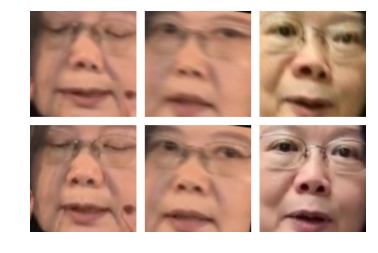

In [5]:
jolin_alignfaces=glob.glob('images data/jolin align faces/frame_*.jpg')
president_alignfaces=glob.glob('images data/president align faces/frame_*.jpg')
shelters=glob.glob('images data/shelter/*.png')
random.shuffle(jolin_alignfaces)
random.shuffle(president_alignfaces)

#測量focus
def focus_measure(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def is_blur(image):
    if cv2.Laplacian(image, cv2.CV_64F).var()<45.:
        return True
    else:
        return False


def next_minibatch(minibatch_size,source='jolin',is_train=True):
    #指派數據來源
    data=jolin_alignfaces
    if source =='president':
        data=president_alignfaces
        
    targets = []
    warpImgs = []
    masks=[]
    while len(targets) < minibatch_size:
        try:
            img_path=random.choice(data) #對其臉部照片
            msk_path=img_path.replace('faces','masks')
            im=cv2.imread(img_path)
            mk=cv2.imread(msk_path,2)
            #print('{0}  {1}'.format(img_path,focus_measure(im)))
            if not is_blur(im): #樣本只使用不模糊的圖片，以確保生成結果的清晰
                if (source =='president' or (source =='jolin' and int(img_path.split('_')[-1].split('.')[0])<2000)) and random.randint(0,10)%4==0:
                    shelter=cv2.imread(random.choice(shelters),cv2.IMREAD_UNCHANGED)
                    shelter_mask=shelter[:,:,3]
                    shelter_mask=shelter_mask/255.

                    shelter_img=shelter[:,:,:3]
                    im=shelter_img*np.expand_dims(shelter_mask,-1)+im*(1-np.expand_dims(shelter_mask,-1))
                    mk=shelter_mask+mk*(1-shelter_mask)

                if is_train and random.randint(0,10)%2==0:#數據增強 調整亮度
                    gamma=np.random.choice(np.arange(0.6, 1.5, 0.05))
                    im=adjust_gamma(im,gamma)

                target_image,target_mask=random_transform(im, mk)  

                warped_image, target_image = random_warp(target_image)
                #warped_image再加入噪點以及模糊化
                if is_train:
                    warped_image=add_noise(warped_image)
                    if random.randint(0,10)%5==0:
                        warped_image=adjust_blur(warped_image)
                    elif random.randint(0,10)%5<=3:
                        warped_image=motion_blur(warped_image)
                    if random.randint(0,10)%3==0:
                        warped_image=random_channel_shift(warped_image)

                targets.append((np.transpose(target_image,[2, 0, 1])-127.5)/127.5) #從HWC轉成CHW
                warpImgs.append((np.transpose(warped_image,[2, 0, 1])-127.5)/127.5)
                masks.append((target_mask-127.5)/127.5)
        except OSError as e:
            print(e)
    random.shuffle(jolin_alignfaces)
    random.shuffle(president_alignfaces)
    return np.asarray(targets).astype(np.float32),np.asarray(warpImgs).astype(np.float32),np.asarray(masks).astype(np.float32)


sample_target,sample_warp,sample_mask=next_minibatch(minibatch_size=3,source='president')

merge_img=np.ones((3,128*2+10,128*3+20))*255

merge_img[:,:128,:128]=sample_warp[0] *127.5+127.5
merge_img[:,:128,138:138+128]=sample_warp[1] *127.5+127.5
merge_img[:,:128,276:276+128]=sample_warp[2] *127.5+127.5
merge_img[:,138:,:128]=sample_target[0] *127.5+127.5
merge_img[:,138:,138:138+128]=sample_target[1] *127.5+127.5
merge_img[:,138:,276:276+128]=sample_target[2] *127.5+127.5


merge_img=array2img(merge_img)
plt.axis('off')
plt.imshow(merge_img)

In [6]:

def self_attn_block(x,num_filters, squeeze_factor=8):
    '''
    代碼來自於 https://github.com/taki0112/Self-Attention-GAN-Tensorflow
    '''
    f = Convolution((1, 1), num_filters // squeeze_factor, pad=True, name='f_conv')(x)
    g = Convolution((1, 1), num_filters // squeeze_factor, pad=True, name='g_conv')(x)
    h = Convolution((1, 1), num_filters, pad=True, name='h_conv')(x)

    h_shape = h.shape

    flat_f = reshape(f, (-1,f.shape[0])) 
    flat_g = reshape(g, (-1,g.shape[0])) 
    flat_h = reshape(h, (-1,h.shape[0]))  

    s = times_transpose(flat_g, flat_f)  #(1024,1024) [N,N]  N = h * w

    beta = softmax(s,-1)
    o = times(beta, flat_h)##(1024,128)  [ N, C]
    o = reshape(o, (h_shape[1], h_shape[2], h_shape[0]))
    o = transpose(o, [2, 0, 1])
    gamma = Parameter(1, init=0.0)
    x = gamma * o + x
    return x



def pixel_shuffle(x,scale):
    h=x.shape[1]
    w=x.shape[2]
    x = C.reshape(x, (x.shape[0]//(scale*scale),scale,scale, x.shape[1], x.shape[2]))
    x = transpose(x,[0,3,4,1,2])
    
    slicelist = [x[:,i,:,:,:] for i in range(h)]
    x=splice(*slicelist,axis=3)
    slicelist = [x[:,:,i,:,:] for i in range(w)]
    x=splice(*slicelist,axis=4)
    x = squeeze(x)
    return x

In [7]:

def conv_bn_leaky_relu(input, filter_size, num_filters, strides=(1, 1), init=C.xavier(0.0005),dilation=1, bias=False):
    c = Convolution2D(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides,dilation=dilation, bias=bias)(input)
    r = BatchNormalization()(c)
    return leaky_relu(r)

def conv_bn_relu(input, filter_size, num_filters, strides=(1, 1), init=C.xavier(0.0005),dilation=1, bias=False):
    c = Convolution2D(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides,dilation=dilation, bias=bias)(input)
    r = BatchNormalization()(c)
    return relu(r)


def conv_leaky_relu(input, filter_size, num_filters, strides=(1, 1), init=C.xavier(0.0005),dilation=1, bias=False):
    r = Convolution2D(filter_size, num_filters, activation=leaky_relu, init=init, pad=True, strides=strides,dilation=dilation, bias=bias)(input)
    return r


def resnet_basic(input, num_filters,dilation=1):
    c1 = conv_bn_relu(input, (3, 3), num_filters,dilation=dilation, bias=False)
    c2 = Convolution2D((3,3), num_filters, activation=None, pad=True, strides=1,init=C.xavier(0.0005),dilation=dilation, bias=False)(c1)
    c2 = BatchNormalization()(c2)
    p = 0.2*c2 + input
    return relu(p)




def upscale(input,num_filters):
    x=conv_bn_leaky_relu(input,(3,3),num_filters*4, strides=(1, 1), init=C.xavier(0.0005))
    x=pixel_shuffle(x,2)
    return x
    



In [8]:
def Encoder():
    def apply_x(x):
        x = conv_bn_leaky_relu(x,(5, 5), 32, strides=2) #32,64,64
        x = conv_bn_leaky_relu(x,(5, 5), 64, strides=2) #64,32,32
        x = resnet_basic(x,64)
        x = self_attn_block(x,64)
        x = conv_bn_leaky_relu(x,(3, 3), 128, strides=2) #128,16,16
        x = conv_bn_leaky_relu(x,(3, 3), 256, strides=2) #256,8,8
        x = resnet_basic(x,256)
        x = self_attn_block(x,256)
        x = conv_bn_leaky_relu(x,(3, 3), 512, strides=2) #512,4,4
        x = conv_bn_leaky_relu(x,(3, 3), 1024, strides=1) #1024,4,4
        x = reshape(x,-1)
        x = Dense(1024)(x)
        #進行一小段解碼
        x = Dense(4*4*(1024//2))(x)
        x = reshape(x,(512,4,4)) #512,4,4
        return x
    return apply_x
    

def Decoder():#8, 8, 512
    def apply_x(x):
        x = upscale(x,512) #512,8,8
        x = resnet_basic(x,512)
        x = upscale(x,256) #256,16,16
        x = resnet_basic(x,256)
        x = upscale(x,128) #128,32,32
        x = self_attn_block(x,128)
        x = upscale(x,64) #64,64,64
        x = resnet_basic(x,64)
        x = upscale(x,32) #32,128,128
        x = conv_bn_leaky_relu(x,(5, 5), 32, strides=1)
        x = Convolution2D((1,1), 3, activation=tanh, init=xavier(0.0005), pad=True, strides=1, bias=False)(x)
        return x
    return apply_x
    
    

In [9]:
#把圖片並列列印出來
def tile_rgb_images(inputA,targetA,aeA,fakeB ,inputB,targetB,aeB,fakeA, row=3, col=8):
    fig = pylab.gcf()
    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 8 == 0:
            img = array2img(inputA[int(m / 8)]*127.5+127.5)
        elif m % 8 == 1:
            img = array2img(targetA[int((m - 1) / 8)]*127.5+127.5)
        elif m % 8 == 2:
            img = array2img(aeA[int((m - 2) / 8)]*127.5+127.5)
        elif m % 8 == 3:
            img = array2img(fakeB[int((m - 3) / 8)]*127.5+127.5)
        elif m % 8 == 4:
            img = array2img(inputB[int((m - 4) / 8)]*127.5+127.5)
        elif m % 8 == 5:
            img = array2img(targetB[int((m - 5) / 8)]*127.5+127.5)
        elif m % 8 == 6:
            img = array2img(aeB[int((m - 6) / 8)]*127.5+127.5)
        else:
            img = array2img(fakeA[int((m - 7) / 8)]*127.5+127.5)
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")
    pylab.savefig('Models/cntk_result.png', bbox_inches='tight')

In [10]:
def l2_loss(y_pred, y_true):
    diff = y_pred - y_true
    return np.square(diff) / 2

def l1_loss(y_pred, y_true):
    diff = y_pred - y_true
    return np.abs(diff)

def staircase_loss(y_true, y_pred, a = 16.0, c=1.0/255.0):
    h = c
    w = c
    x = clip(abs(y_true - y_pred) - 0.5 * c, 0.0, 1.0)
    loss = h*( tanh(a*((x/w)-floor(x/w)-0.5)) / ( 2.0*tanh(a/2.0) ) + 0.5 + floor(x/w)) 
    loss += 1e-10
    return reduce_mean(loss, axis=0)

In [ ]:
minibatch_size=10
learning_rate=1e-5
epochs=20

input_var=input_variable((3,128,128),dtype=np.float32)  
target_var=input_variable((3,128,128),dtype=np.float32)  
mask_var=input_variable((128,128),dtype=np.float32)  

mask_var1=reshape(mask_var,(1,128,128))

encoder_share=Encoder()
decoder_A=Decoder()
decoder_B=Decoder()

autoencoder_A=decoder_A(encoder_share(input_var))
autoencoder_B=decoder_B(encoder_share(input_var))
if os.path.exists('Models/autoencoder_A_cntk.cnn'):
    recover_modelA = C.Function.load('Models/autoencoder_A_cntk.cnn')
    autoencoder_A = recover_modelA(input_var)
    print("載入既有autoencoder_A模型累積訓練")
    
if os.path.exists('Models/autoencoder_B_cntk.cnn'):
    recover_modelB = C.Function.load('Models/autoencoder_B_cntk.cnn')
    autoencoder_B = recover_modelB(input_var)
    print("載入既有autoencoder_B模型累積訓練")
print(encoder_share(input_var).shape)
loss_A=l2_loss(target_var,autoencoder_A)+l1_loss(target_var,autoencoder_A)+l2_loss(target_var*mask_var1,autoencoder_A*mask_var1)+0.2*staircase_loss(target_var,autoencoder_A)
loss_B=l2_loss(target_var,autoencoder_B)+l1_loss(target_var,autoencoder_B)+l2_loss(target_var*mask_var1,autoencoder_B*mask_var1)+0.2*staircase_loss(target_var,autoencoder_B)

pp_A = C.logging.ProgressPrinter(50)
pp_B = C.logging.ProgressPrinter(50)

A_learner = C.adam(
        parameters=autoencoder_A.parameters,
        lr=C.learning_rate_schedule(learning_rate, C.UnitType.sample),
        momentum= momentum_schedule(0.9),
        #variance_momentum=momentum_schedule_per_sample(0.999),
        #l1_regularization_weight=1e-3, 
        l2_regularization_weight=5e-4,
        unit_gain =False,
        use_mean_gradient=True)

B_learner = C.adam(
    parameters=autoencoder_B.parameters,
    lr=C.learning_rate_schedule(learning_rate, C.UnitType.sample),
    momentum=momentum_schedule(0.9),
    #variance_momentum=momentum_schedule_per_sample(0.999),
    #l1_regularization_weight=1e-3, 
    l2_regularization_weight=5e-4, 
    unit_gain =False,
    use_mean_gradient=True)

A_trainer = C.Trainer(autoencoder_A,(loss_A, sqrt(reduce_sum(squared_error(target_var,autoencoder_A))/(128*128*3))),A_learner,pp_A)
B_trainer = C.Trainer(autoencoder_B,(loss_B, sqrt(reduce_sum(squared_error(target_var,autoencoder_B))/(128*128*3))),B_learner,pp_B)

載入既有autoencoder_A模型累積訓練
載入既有autoencoder_B模型累積訓練
(512, 4, 4)


In [ ]:
mbs = 0
for epoch in range(epochs):
    mbs = 0
    while mbs <1000:
        raw_target1,raw_warp1,raw_mask1= next_minibatch(minibatch_size,source='jolin',is_train=True)
        A_trainer.train_minibatch({input_var:raw_warp1,target_var:raw_target1,mask_var:raw_mask1})
        
        raw_target2,raw_warp2,raw_mask2= next_minibatch(minibatch_size,source='president',is_train=True)
        B_trainer.train_minibatch({input_var:raw_warp2,target_var:raw_target2,mask_var:raw_mask2})
        
        if (mbs+1) % 50 == 0 :
            autoencoder_A.save('Models/autoencoder_A_cntk.cnn')
            autoencoder_B.save('Models/autoencoder_B_cntk.cnn')
            autoencoder_A.save('Models/autoencoder_A_cntk0.cnn')
            autoencoder_B.save('Models/autoencoder_B_cntk0.cnn')
            
            aeA=autoencoder_A(raw_target1)
            fakeA=autoencoder_A(raw_target2)
            aeB=autoencoder_B(raw_target2)
            fakeB=autoencoder_B(raw_target1)
            tile_rgb_images(raw_warp1,raw_target1,aeA,fakeB,raw_warp2,raw_target2,aeB,fakeA)
            
        if (mbs+1) % 500 == 0 :
            learning_rate=learning_rate*0.75  #每隔500次，學習速率降一半，否則很容易原本下降的損失函數又會突然暴漲
            print('learning rate:{0:.3}'.format(learning_rate))
        mbs += 1

    autoencoder_A.save('Models/autoencoder_A_cntk.cnn')
    autoencoder_B.save('Models/autoencoder_B_cntk.cnn')

Learning rate per minibatch: 1e-05
Learning rate per minibatch: 1e-05
 Minibatch[   1-  50]: loss = 5262.321500 * 500, metric = 11.44% * 500;
 Minibatch[   1-  50]: loss = 4763.047500 * 500, metric = 10.43% * 500;
 Minibatch[  51- 100]: loss = 5146.564500 * 500, metric = 11.18% * 500;
 Minibatch[  51- 100]: loss = 4773.207500 * 500, metric = 10.40% * 500;
 Minibatch[ 101- 150]: loss = 5279.349000 * 500, metric = 11.46% * 500;
 Minibatch[ 101- 150]: loss = 4828.344000 * 500, metric = 10.52% * 500;
 Minibatch[ 151- 200]: loss = 5277.231000 * 500, metric = 11.50% * 500;
 Minibatch[ 151- 200]: loss = 4865.935000 * 500, metric = 10.53% * 500;
 Minibatch[ 201- 250]: loss = 5268.672000 * 500, metric = 11.44% * 500;
 Minibatch[ 201- 250]: loss = 4792.826000 * 500, metric = 10.47% * 500;
 Minibatch[ 251- 300]: loss = 5171.498000 * 500, metric = 11.22% * 500;
